# AB Testing - Study Notebook
 *By Yi Zhang*
1. [A/B Test Design](#about) <br>
1.1 [Scenario Not for A/B Test](#not) <br>
1.2 [Random Split and Assign](#random) <br>
1.2.1 [Unit of Diversion: People vs Event](#unit) <br>
1.2.2 [Situations without Independence](#independence) <br>
2. [Experiment Overview](#overview)<br>
2.1 [Current Conditions Before Change](#current)<br>
2.2 [Description of Experimented Change](#description)<br>
2.3 [Experiment Hypothesis](#hypothesis)<br>
2.4 [Experiment Details](#details)<br>
3. [Metric Choice](#metricchoice)<br>
3.1 [Invariate Metrics - Sanity Checks](#invariate)<br>
3.2 [Evaluation Metrics - Performance Indicators](#evaluation)<br>
4. [Estimating the baseline values of metrics](#baseline)<br>
4.1 [Collecting estimators data](#collect)<br>
4.2 [Estimating Stadard Deviation](#sd)<br>
4.2.1 [Scaling Collected Data](#scale)<br>
4.2.2 [Estimating Analytically](#estimate)<br>
5. [Experiment Sizing](#sizing)<br>
5.1 [Get Z-score critical value and Standard Deviations](#z)<br>
5.2 [Calculate Sample Size per Metric](#calc) <br>
6. [Analyzing Collected Data](#analysis)<br>
6.1 [Loading collected data](#collect_results)<br>
6.2 [Sanity Checks](#sanity)<br>
6.2.1 [Sanity Checks for difference between Counts](#check_counts)<br>
6.2.2 [Sanity Checks for difference between probabilities](#check_probs)<br>
6.3 [Measuring effect size](#effect)<br>
6.4 [Double check with Sign Tests](#sign_tests)<br>
6.4.1 [Data Preparation](#prep)<br>
6.4.2 [Building a Sign Test](#sign)<br>
7. [Conclusions & Recommendations](#conclusions)<br>

In [1]:
import math as mt
import numpy as np
import pandas as pd
from scipy.stats import norm

## 1 A/B Test Design <a class="anchor" id="about"></a>
Udacity's [AB Testing course](https://www.udacity.com/course/ab-testing--ud257) is presented by Google and focuses on design and analysis of A/B tests.

The typical 3 steps of an A/B Test Design are that i) randomly split and assign, ii) measure and iii) compare.

### 1.1 Scenario Not for A/B Test <a class="anchor" id="not"></a>
* A/B test is not good at new experience because the baseline and time for users to adapt is unknown. 
    * Learning Effect: novelty effect and change aversion.
    * Typical way to avoid learning effect: samples on new users (may lose important information of old users).
* A/B test won't tell what we are missing. 
    * For such qualitative research, we can consider focus groups and customer research.
    
### 1.2  Random Split and Assign <a class="anchor" id="random"></a>

#### 1.2.1 Unit of Diversion: People vs Event <a class="anchor" id="unit"></a>
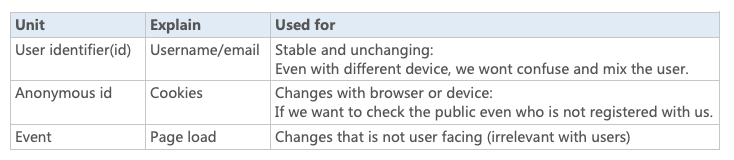

#### 1.2.2 Situations without Independence  <a class="anchor" id="independence"></a>
In probability theory, the [central limit theorem (CLT)](https://en.wikipedia.org/wiki/Central_limit_theorem) establishes that, in some situations, when independent random variables are added, their properly normalized sum tends toward a normal distribution even if the original variables themselves are not normally distributed.

Certain conditions musbe met to use CLT: Independent Samples Test
* Randomization: Each sample should represent a random sample from the population or at least follow the population distribution.
* 10% Rule: The sample size must not be bigger than 10% of the entire population.
* Large Enough Sample Size: sample size n should be large enough so that np>= 10 and nq>=10. (at least 30)
    
In A/B test, we need to ensure the independence that user behavior in one group does not affect that in another.

However, in some situations, groups will affect each other.
* Marketplace involves 2-side or 3-side such as:
    * Uber: rider & driver
    * Airbnb: guest & host
* Network that one user may share information to friends such as:
    * Snap, Facebook and LinkedIn

To overcome the above, we can select samples by higher level. Take User as an example:
* We cannot randomly split drivers since they would not be independent. They will influence each other. 
    * If I take all drivers in Seattle and give 50& of them with new app and 50% keep using the old app.
    * If the new app is effectively making drivers take more trips, that will result in higher competition for drivers using the old app, therefore, will affect their earnings.
    * If the new app sucks and those drivers drive less, this will also affect old app drviers earnings given that there is less competition.
* Therefore, I will test 'by market' instead of 'in a market'. 
    * I will match comparable markets in pairs. 
    * Comparable means that during the time of the test, the main metrics (in this case: num of trips per driver) are expected to be very similiar, if there were no test.
    * For each pair, I will give everyone in one marketing the new app and in the other one the old app.

## 2 Experiment Overview <a class="anchor" id="overview"></a>

**Experiment Name:** "Free Trial" Screener. <br>
It is conducted by Udacity, a website dedicated to teaching online - with the overall business goal of maximizing course completion by students.
### 2.1 Current Conditions Before Change <a class="anchor" id="current"></a>
* At the time of this experiment, Udacity courses currently have two options on the course overview page: "start free trial", and "access course materials". <br>
* If the student clicks "start free trial", they will be asked to enter their credit card information, and then they will be enrolled in a free trial for the paid version of the course. After 14 days, they will automatically be charged unless they cancel first.
* If the student clicks "access course materials", they will be able to view the videos and take the quizzes for free, but they will not receive coaching support or a verified certificate, and they will not submit their final project for feedback.


### 2.2 Description of Experimented Change <a class="anchor" id="description"></a>

* In the experiment, Udacity tested a change where if the student clicked "start free trial", they were asked how much time they had available to devote to the course.
* If the student indicated 5 or more hours per week, they would be taken through the checkout process as usual. If they indicated fewer than 5 hours per week, a message would appear indicating that Udacity courses usually require a greater time commitment for successful completion, and suggesting that the student might like to access the course materials for free.
* At this point, the student would have the option to continue enrolling in the free trial, or access the course materials for free instead. [This screenshot](https://drive.google.com/file/d/0ByAfiG8HpNUMakVrS0s4cGN2TjQ/view) shows what the experiment looks like.

### 2.3 Experiment Hypothesis <a class="anchor" id="hypothesis"></a>
The hypothesis was that this might set clearer expectations for students upfront, thus reducing the number of frustrated students who left the free trial because they didn't have enough time—without significantly reducing the number of students to continue past the free trial and eventually complete the course. If this hypothesis held true, Udacity could improve the overall student experience and improve coaches' capacity to support students who are likely to complete the course.

### 2.4 Experiment Details <a class="anchor" id="details"></a>
The unit of diversion is a cookie, although if the student enrolls in the free trial, they are tracked by user-id from that point forward. The same user-id cannot enroll in the free trial twice. For users that do not enroll, their user-id is not tracked in the experiment, even if they were signed in when they visited the course overview page.

## 3 Metric Choice <a class="anchor" id="metric"></a>
We need two types of metrics for a successful experiment (or at least, a safe one); Invariate and evaluation metrics.
Invariate metrics are used for "sanity checks", that is, to make sure our experiment (the way we presented a change to a part of the population, as well as the way we collected the data) is not inherently wrong. Basically, this means we pick metrics which we consider not to change (not to be affected) because of our experiment and later make sure these metrics don't change drastically between our control and experiment groups.<br>
Evaluation metrics on the other hand, are the metrics in which we expect to see a change, and are relevant to the business goals we aim to achieve. For each metric we state a $Dmin$ - which marks the minimum change which is practically significant to the business. For instance, stating that any increase in retention that is under 2%, even if statistically significant, is not practical to the business.
### 3.1 Invariate Metrics - Sanity Checks <a class="anchor" id="invariate"></a>

| Metric Name  | Metric Formula  | $Dmin$  | Notation |
|:-:|:-:|:-:|:-:|
| Number of Cookies in Course Overview Page  | # unique daily cookies on page | 3000 cookies  | $C_k$ |
| Number of Clicks on Free Trial Button  | # unique daily cookies who clicked  | 240 clicks | $C_l$ |
| Free Trial button Click-Through-Probability  | $\frac{C_l}{C_k}$ | 0.01  | $CTP$ | 

### 3.2 Evaluation Metrics - Performance Indicators <a class="anchor" id="evaluation"></a>
| Metric Name  | Metric Formula  | $Dmin$  | Notation |
|:-:|:-:|:-:|:-:|
| Gross Conversion   |  $\frac{enrolled}{C_l}$  | 0.01  | $Conversion_{Gross}$ |
| Retention   | $\frac{paid}{enrolled}$  | 0.01  | $Retention$ |
| Net Conversion  |  $\frac{paid}{C_l}$  | 0.0075 | $Conversion_{Net}$ |

## 4 Estimating the baseline values of metrics <a class="anchor" id="baseline"></a>
Before we start our experiment we should know how these metrics behave before the change - that is, what are their baseline values.
### 4.1 Collecting estimators data <a class="anchor" id="collect"></a>
Udacity gives the following rough estimates for these metrics (presumably collected from aggregates on daily traffic) <br>

| Item | Description  | Estimator  |
|:-:|:-:|:-:|
| Number of cookies | Daily unique cookies to view course overview page  | 40,000  |
| Number of clicks | Daily unique cookies to click Free Trial button  | 3,200 |
| Number of enrollments | Free Trial enrollments per day  | 660  |
| CTP | CTP on Free Trial button  | 0.08  |
| Gross Conversion | Probability of enrolling, given a click  | 0.20625  |
| Retention | Probability of payment, given enrollment  | 0.53  |
| Net Conversion | Probability of payment, given click  | 0.109313 |

In [2]:
#Let's place this estimators into a dictionary for ease of use later
baseline = {"Cookies":40000,"Clicks":3200,"Enrollments":660,"CTP":0.08,"GConversion":0.20625,
           "Retention":0.53,"NConversion":0.109313}

### 4.2 Estimating Standard Deviation <a class="anchor" id="sd"></a>
Once we collected these estimates, we should estimate the standard deviation of a metric, this is computed for sample size calculations and confidence intervals for our results. The more variant a metric is, the harder it is to reach a significant result. Assuming a sample size of 5,000 cookies visiting the course overview page per day (as given in project's instructions) - we want to estimate a standard deviation, for the evaluation metrics only. The sample size we are considering should be smaller than the "population" we collected and small enough to have two groups with that size.

#### 4.2.1 Scaling Collected Data <a class="anchor" id="scale"></a>
For all the calculations to follow we need to scale our collected counts estimates of metrics with the sample size we specified for variance estimation. In this case, from 40000 unique cookies to visit the course overview page per day, to 5000.

In [3]:
#Scale The counts estimates
baseline["Cookies"] = 5000
baseline["Clicks"]=baseline["Clicks"]*(5000/40000)
baseline["Enrollments"]=baseline["Enrollments"]*(5000/40000)
baseline

{'CTP': 0.08,
 'Clicks': 400.0,
 'Cookies': 5000,
 'Enrollments': 82.5,
 'GConversion': 0.20625,
 'NConversion': 0.109313,
 'Retention': 0.53}

#### 4.2.2 Estimating Analytically <a class="anchor" id="estimate"></a>
In order to estimate variance analytically, we can assume metrics which are probabilities ($\hat{p}$) are binomially distributed, so we can use this formula for the standard deviation: <br>
<center><font size="4">$SD=\sqrt{\frac{\hat{p}*(1-\hat{p})}{n}}$</font></center><br>
This assumption is only valid when the **unit of diversion** of the experiment is equal to the **unit of analysis** (the denominator of the metric formula). In the cases when this is not valid, the actual variance might be different and it is recommended to estimate it empirically.

For each metric, we need to plug two variables into the formula: <br>
$\hat{p}$ - baseline probability of the event to occur <br>
$ n $ - sample size <br>


* **Gross Conversion** - The baseline probability for Gross Conversion can be calculated by the number of users to enroll in a free trial divided by the number of cookies clicking the free trial. In other words, the probability of enrollment given a click. In this case, the unit of diversion (Cookies), that is the element by which we differentiate samples and assign them to control and experiment groups, is equall to the unit of analysis (cookies who click), that is the denominator of the formula to calculate Gross Conversion (GC). When this is the case, this analytic estimate of variance is sufficient.


In [4]:
# Let's get the p and n we need for Gross Conversion (GC)
# and compute the Stansard Deviation(sd) rounded to 4 decimal digits.
GC={}
GC["d_min"]=0.01
GC["p"]=baseline["GConversion"]
#p is given in this case - or we could calculate it from enrollments/clicks
GC["n"]=baseline["Clicks"]
GC["sd"]=round(mt.sqrt((GC["p"]*(1-GC["p"]))/GC["n"]),4)
GC["sd"]

0.0202

* **Retention** - The baseline probability for retention is the number of paying users (enrolled after 14 free days) divided by the number of total enrolled users. In other words, the probability of payment, given enrollment. The sample size is the number of enrolled users. In this case, unit of diversion is not equal to unit of analysis (users who enrolled) so an analytical estimation is not enough - if we had the data for these estimates, we would want to estimate this variance empirically as well.

In [5]:
# Let's get the p and n we need for Retention(R)
# and compute the Stansard Deviation(sd) rounded to 4 decimal digits.
R={}
R["d_min"]=0.01
R["p"]=baseline["Retention"]
R["n"]=baseline["Enrollments"]
R["sd"]=round(mt.sqrt((R["p"]*(1-R["p"]))/R["n"]),4)
R["sd"]

0.0549

* **Net Conversion** - The baseline probability for the net conversion is the number of paying users divided by the number of cookies that clicked the free trial button. In other words, the probability of payment, given a click. The sample size is the number of cookies that clicked. In this case, the unit of analysis and diversion are equal so we expect a good enough estimation analytically.

In [6]:
# Let's get the p and n we need for Net Conversion (NC)
# and compute the Standard Deviation (sd) rounded to 4 decimal digits.
NC={}
NC["d_min"]=0.0075
NC["p"]=baseline["NConversion"]
NC["n"]=baseline["Clicks"]
NC["sd"]=round(mt.sqrt((NC["p"]*(1-NC["p"]))/NC["n"]),4)
NC["sd"]

0.0156

## 5 Experiment Sizing <a class="anchor" id="sizing"></a>
At this point, once we have estimated our metrics in the baseline (most importantly, their estimated variance) we cancalculate the munumal number of samples we need so that our experiment will have enough statistical power, as well as siginificance.

Given $\alpha=0.05$ (significance level ) and $\beta=0.2$ (power), we want to estimate how many total pageviews (cookies who viewed the course overview page) we need in the experiment. This amount will be divided into tthe two groups: control and experiment. This calculation can be done using an [online calculator](http://www.evanmiller.org/ab-testing/sample-size.html) or by calculating directly using the required formula.

The minimum sample size for control and experiment groups, which provides probability of Type I Error $\alpha$, Power $1-\beta$, detectable effect $d$ and baseline conversion rate $p$ (simple hypothesis $H_0 : P_{cont} - P_{exp} = 0$ against simple alternative $H_A : P_{cont} - P_{exp} = d$  is:

<center> <font size="5"> $n = \frac{(Z_{1-\frac{\alpha}{2}}sd_1 + Z_{1-\beta}sd_2)^2}{d^2}$</font>, with: <br><br>
$sd_1 = \sqrt{p(1-p)+p(1-p)}$<br><br>
$sd_2 = \sqrt{p(1-p)+(p+d)(1-(1-(p+d))}$ </center><br>

Now, let's break down what inputs we need and which calculations still need to be made. Regarding inputs, we have all the data we need:
Type 1 error ($\alpha$), power ($1-\beta$), detectable change ($d = D_{min}$) and baseline conversion rate (our $\hat{p}$ ).
What we need to calculate: 
* Get Z score for $1-\frac{\alpha}{2}$ and for $1-\beta$
* Get standard deviations 1 & 2, that is for both the baseline and for expected changed rate
All these components will finally yield the number we need.

### 5.1 Get z-score critical value and Standard Deviations <a class="anchor" id="side_methods"></a>
We are used to looking up this value in a table, but gladly we can use python's `scipy.stats.norm` package to get all the required methods for normal distribution. The `ppf` method gives us access to the [Percent Point Function (ppf)](https://en.wikipedia.org/wiki/Quantile_function) or Quantile Function, and besides it being the inverse of the [Cummulative Distribution Function (cdf)](https://en.wikipedia.org/wiki/Cumulative_distribution_function), this is the functions that will give back our required critical z-score.

In [7]:
def get_sds(p,d):
    sd1=mt.sqrt(2*p*(1-p))
    sd2=mt.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    x=[sd1,sd2]
    return x

In [8]:
#Inputs: required alpha value (alpha should already fit the required test)
#Returns: z-score for given alpha
def get_z_score(alpha):
    return norm.ppf(alpha)

# Inputs p-baseline conversion rate which is our estimated p and d-minimum detectable change
# Returns
def get_sds(p,d):
    sd1=mt.sqrt(2*p*(1-p))
    sd2=mt.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

# Inputs:sd1-sd for the baseline,sd2-sd for the expected change,alpha,beta,d-d_min,p-baseline estimate p
# Returns: the minimum sample size required per group according to metric denominator
def get_sampSize(sds,alpha,beta,d):
    n=pow((get_z_score(1-alpha/2)*sds[0]+get_z_score(1-beta)*sds[1]),2)/pow(d,2)
    return n

### 5.2 Calculate Sample Size per Metric <a class="anchor" id="calc"></a>
OK! Looks like we set up all the tools required for this part. We are now going to calculate the number of samples required for the experiment per metric, and we are subected to the fact that the highest sample size will be the effective size. This size should be considered in terms of efficacy of duration and exposure: how long will it take to get this many samples for the experiment.

So, to work more easily, let's add the d parameter to each of the metrics characteristics of each metric:

In [9]:
GC["d"]=0.01
R["d"]=0.01
NC["d"]=0.0075

Now, for the calculations
* **Gross Conversion**


In [10]:
# Let's get an integer value for simplicity
GC["SampSize"]=round(get_sampSize(get_sds(GC["p"],GC["d"]),0.05,0.2,GC["d"]))
GC["SampSize"]

25835.0

This means we need at least 25,835 cookies who click the Free Trial button - per group! That means that if we got 400 clicks out of 5000 pageviews (`400/5000 = 0.08`) -> So, we are going to need `GC["SampSize"]/0.08 = 322,938` pageviews, again ; per group! Finally, the total amount of samples per the Gross Conversion metric is:

In [11]:
GC["SampSize"]=round(GC["SampSize"]/0.08*2)
GC["SampSize"]

645875.0

* Retention

In [12]:
# Getting a nice integer value
R["SampSize"]=round(get_sampSize(get_sds(R["p"],R["d"]),0.05,0.2,R["d"]))
R["SampSize"]

39087.0

This means that we need 39,087 users who enrolled per group! We have to first convert this to cookies who clicked, and then to cookies who viewed the page, then finally to multipky by two for both groups.

In [13]:
R["SampSize"]=R["SampSize"]/0.08/0.20625*2
R["SampSize"]

4737818.1818181816

This takes us as high as over 4 million page views total, this is practically impossible because we know we get about 40,000 a day, this would take well over 100 days. This means we have to drop this metric and not continue to work with it because results from our experiment (which is much smaller) will be biased.
* **Net Conversion**

In [14]:
# Getting a nice integer value
NC["SampSize"]=round(get_sampSize(get_sds(NC["p"],NC["d"]),0.05,0.2,NC["d"]))
NC["SampSize"]

27413.0

So, needing 27,413 cookies who click per group takes us all the way up to:

In [15]:
NC["SampSize"]=NC["SampSize"]/0.08*2
NC["SampSize"]

685325.0

We are all the way up to 685,325 cookies who view the page. This is more than what was needed for Gross Conversion, so this will be our number. Assuming we take 80% of each days pageviews, the data collection period for this experiment (the period in which the experiment is revealed) will be about 3 weeks.


## 6 Analyzing Collected Data <a class="anchor" id="analysis"></a>
Finally, the moment we've all been waiting for, after so much preparation we finally get to see what this experiment will prove!
The data is presented as two spreadsheets. I will load each spreadshot into a pandas dataframe.

### 6.1 Loading collected data <a class="anchor" id="collect_results"></a>

In [16]:
# we use pandas to load datasets
control=pd.read_csv("../input/control-data/control_data.csv")
experiment=pd.read_csv("../input/experiment-data/experiment_data.csv")
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


### 6.2 Sanity Checks <a class="anchor" id="sanity"></a>
First thing we have to do before even beginning to analyze this experiment's results is sanity checks. These checks help verify that the experiment was conducted as expected and that other factors did not influence the data which we collected. This also makes sure that data collection was correct.

We have 3 Invariant metrics:: 
* Number of Cookies in Course Overview Page
* Number of Clicks on Free Trial Button
* Free Trial button Click-Through-Probability

Two of these metrics are simple counts like number of cookies or number of clicks and the third is a probability (CTP). We will use two different ways of checking whether these obsereved values are like we expect (if in fact the experiment was not damaged.

#### 6.2.1 Sanity Checks for differences between counts <a class="anchor" id="check_counts"></a>
* **Number of cookies who viewed the course overview page** - Starting from this simpel invariant metric, we want to count the total amount of cookie pageviews we diverted to each group and see if there is a significant difference int he amount of cookies. A significant difference will imply a biased experiment that we should not rely on it's results.

In [17]:
pageviews_cont=control['Pageviews'].sum()
pageviews_exp=experiment['Pageviews'].sum()
pageviews_total=pageviews_cont+pageviews_exp
print ("number of pageviews in control:", pageviews_cont)
print ("number of Pageviewsin experiment:" ,pageviews_exp)

number of pageviews in control: 345543
number of Pageviewsin experiment: 344660


Ok so these look like pretty close numbers. Now, let's make sure this difference in amounts is not significant and is random and even like we expected. We can model this diversion in the following way: <br>
We expect the amount of pageviews in the control group to be about a half (50%) of the total pageviews in both groups, so we can define a random variable with an easy to use distribution. <br>
A binomial random variable will be the number of successes we can expect to get out of N experiments, given the probability of a single success. So, if we consider being assigned to a group (control, for example) a success with probability 0.5 (random!), the number of samples which get assigned to the group is the value of our random binomial variable! <br>

This get's easier thanks to the central limit theorem which let's us approximate the binomial distribution to a normal distribution (when n is large enough) with a mean of $p$ and a standard deviation $\sqrt{\frac{p(1-p)}{N}}$
<center> <font size="4"> $ X$~$N( p,\sqrt{\frac{p(1-p)}{N}})$ </font></center>
What we want to test is whether our observed $\hat{p}$ (number of samples in control divided by total number of damples in both groups) is not significantly different than $p=0.5$. In order to do that we can calculate the margin of error acceptable at a 95% confidence level:
<center> <font size="4"> $ ME=Z_{1-\frac{\alpha}{2}}SD$ </font></center>
Finally, a [confidence interval](https://en.wikipedia.org/wiki/Confidence_interval) can be derived to tell us in which range an observed $p$ can exist and be acceptable as "the same" as the expected value.
<center> <font size="4"> $ CI=[\hat{p}-ME,\hat{p}+ME]$ </font></center>
When our obsereved $\hat{p}$ is within this range, all is well and the test was passed.

In [18]:
p=0.5
alpha=0.05
p_hat=round(pageviews_cont/(pageviews_total),4)
sd=mt.sqrt(p*(1-p)/(pageviews_total))
ME=round(get_z_score(1-(alpha/2))*sd,4)
print ("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.4988 and 0.5012 ; Is 0.5006 inside this range?


Our observed $\hat{p}$ is inside this range which means the difference in number of samples between groups is expected. So far so good, since this invariant metric sanity test passes!
* **Number of cookies who clicked the Free Trial Button**
We are going to address this count with the same strategy as before.

In [19]:
clicks_cont=control['Clicks'].sum()
clicks_exp=experiment['Clicks'].sum()
clicks_total=clicks_cont+clicks_exp

p_hat=round(clicks_cont/clicks_total,4)
sd=mt.sqrt(p*(1-p)/clicks_total)
ME=round(get_z_score(1-(alpha/2))*sd,4)
print ("The confidence interval is between",p-ME,"and",p+ME,"; Is",p_hat,"inside this range?")

The confidence interval is between 0.4959 and 0.5041 ; Is 0.5005 inside this range?


We have another pass! Great, so far it still seems all is well with our experiment results. Now, for the final metric which is a probability.

#### 6.2.2 Sanity Checks for differences between probabilities <a class="anchor" id="check_prob"></a>
* ** Click-through-probability of the Free Trial Button**
In this case, we want to make sure the proportion of clicks given a pageview (our observed CTP) is about the same in both groups (since this was not expected to change due to the experiment). In order to check this out we will calculate the CTP in each group and calculate a confidence interval for the expected difference between them. 

In other words, we expect to see no difference ($CTP_{exp}-CTP_{cont}=0$), with an acceptable margin of error, dictated by our calculated confidence interval. The changes we should notice are for the calculation of the standard error - which in this case is a pooled standard error.

<center><font size="4">$SD_{pool}=\sqrt{\hat{p_{pool}}(1-\hat{p_{pool}}(\frac{1}{N_{cont}}+\frac{1}{N_{exp}})}$</font></center>
with <br> <center><font size="5"> $\hat{p_{pool}}=\frac{x_{cont}+x_{exp}}{N_{cont}+N_{exp}}$ </font></center>
We should understand that CTP is a proportion in a population (amount of events x in a population n) like the amount of clicks out of the amount of pageviews..

In [20]:
ctp_cont=clicks_cont/pageviews_cont
ctp_exp=clicks_exp/pageviews_exp
d_hat=round(ctp_exp-ctp_cont,4)
p_pooled=clicks_total/pageviews_total
sd_pooled=mt.sqrt(p_pooled*(1-p_pooled)*(1/pageviews_cont+1/pageviews_exp))
ME=round(get_z_score(1-(alpha/2))*sd_pooled,4)
print ("The confidence interval is between",0-ME,"and",0+ME,"; Is",d_hat,"within this range?")

The confidence interval is between -0.0013 and 0.0013 ; Is 0.0001 within this range?


Wonderful. It seems this test has passed with flying colors as well.

### 6.3 Examining effect size <a class="anchor" id="effect"></a>
The next step is looking at the changes between the control and experiment groups with regard to our evaluation metrics to make sure the difference is there, that it is statistically significant and most importantly practically significant (the difference is "big" enough to make the experimented change beneficial to the company).

Now, all that is left is to measure for each evaluation metric, the difference between the values from both groups. Then, we compute the confidence interval for that difference and test whether or not this confidence interval is both statistically and practically significant.

* **Gross Conversion**
A metric is statistically significant if the confidence interval does not include 0 (that is, you can be confident there was a change), and it is practically significant if the confidence interval does not include the practical significance boundary (that is, you can be confident there is a change that matters to the business.)

> **Important:** The given spreadsheet lists pageviews and clicks for 39 days, while it only lists enrollments and payments for 23 days. So, when working with enrollments and payments we should notice using only the corresponding pageviews and clicks, and not all of them.

In [21]:
# Count the total clicks from complete records only
clicks_cont=control["Clicks"].loc[control["Enrollments"].notnull()].sum()
clicks_exp=experiment["Clicks"].loc[experiment["Enrollments"].notnull()].sum()

In [22]:
#Gross Conversion - number of enrollments divided by number of clicks
enrollments_cont=control["Enrollments"].sum()
enrollments_exp=experiment["Enrollments"].sum()

GC_cont=enrollments_cont/clicks_cont
GC_exp=enrollments_exp/clicks_exp
GC_pooled=(enrollments_cont+enrollments_exp)/(clicks_cont+clicks_exp)
GC_sd_pooled=mt.sqrt(GC_pooled*(1-GC_pooled)*(1/clicks_cont+1/clicks_exp))
GC_ME=round(get_z_score(1-alpha/2)*GC_sd_pooled,4)
GC_diff=round(GC_exp-GC_cont,4)
print("The change due to the experiment is",GC_diff*100,"%")
print("Confidence Interval: [",GC_diff-GC_ME,",",GC_diff+GC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",-GC["d_min"],"is not in the CI as well.")

The change due to the experiment is -2.06 %
Confidence Interval: [ -0.0292 , -0.012 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if -0.01 is not in the CI as well.


According to this result there was a change due to the experiment, that change was both statistically and practically significant. 
We have a negative change of 2.06%, when we were willing to accept any change greater than 1%. This means the Gross Conversion rate of the experiment group (the one exposed to the change, i.e. asked how many hours they can devote to studying) has decreased as expected by 2% and this change was significant. This means  less people enrolled in the Free Trial after due to the pop-up. 
* **Net Conversion** 
The hypothesis is the same as before just with net conversion instead of gross. At this point we expect the fraction of payers (out of the clicks) to decrease as well.

In [23]:
#Net Conversion - number of payments divided by number of clicks
payments_cont=control["Payments"].sum()
payments_exp=experiment["Payments"].sum()

NC_cont=payments_cont/clicks_cont
NC_exp=payments_exp/clicks_exp
NC_pooled=(payments_cont+payments_exp)/(clicks_cont+clicks_exp)
NC_sd_pooled=mt.sqrt(NC_pooled*(1-NC_pooled)*(1/clicks_cont+1/clicks_exp))
NC_ME=round(get_z_score(1-alpha/2)*NC_sd_pooled,4)
NC_diff=round(NC_exp-NC_cont,4)
print("The change due to the experiment is",NC_diff*100,"%")
print("Confidence Interval: [",NC_diff-NC_ME,",",NC_diff+NC_ME,"]")
print ("The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if",NC["d_min"],"is not in the CI as well.")

The change due to the experiment is -0.49 %
Confidence Interval: [ -0.0116 , 0.0018 ]
The change is statistically significant if the CI doesn't include 0. In that case, it is practically significant if 0.0075 is not in the CI as well.


In this case we got a change size of less than a 0.5%, a very small decrease which is not statistically significant, and as such not practically significant.

## 6.4 Double check with Sign Tests <a class="anchor" id="sign_tests"></a>
In a sign test we get another angle at analyzing the results we got - we check if the trend of change we observed (increase or decrease) was evident in the daily data. We are goint to compute the metric's value per day and then count on how many days the metric was lower in the experiment group and this will be the number of succssesses for our binomial variable. Once this is defined we can look at the proportion of days of success out of all the available days.

### 6.4.1 Data Preparation <a class="anchor" id="prep"></a>

In [24]:
#let's first create the dataset we need for this:
# start by merging the two datasets
full=control.join(other=experiment,how="inner",lsuffix="_cont",rsuffix="_exp")
#Let's look at what we got
full.count()

Date_cont           37
Pageviews_cont      37
Clicks_cont         37
Enrollments_cont    23
Payments_cont       23
Date_exp            37
Pageviews_exp       37
Clicks_exp          37
Enrollments_exp     23
Payments_exp        23
dtype: int64

In [25]:
#now we only need the complete data records
full=full.loc[full["Enrollments_cont"].notnull()]
full.count()

Date_cont           23
Pageviews_cont      23
Clicks_cont         23
Enrollments_cont    23
Payments_cont       23
Date_exp            23
Pageviews_exp       23
Clicks_exp          23
Enrollments_exp     23
Payments_exp        23
dtype: int64

In [26]:
# Perfect! Now, derive a new column for each metric, so we have it's daily values
# We need a 1 if the experiment value is greater than the control value=
x=full['Enrollments_cont']/full['Clicks_cont']
y=full['Enrollments_exp']/full['Clicks_exp']
full['GC'] = np.where(x<y,1,0)
# The same now for net conversion
z=full['Payments_cont']/full['Clicks_cont']
w=full['Payments_exp']/full['Clicks_exp']
full['NC'] = np.where(z<w,1,0)
full.head()

,Date_cont,Pageviews_cont,Clicks_cont,Enrollments_cont,Payments_cont,Date_exp,Pageviews_exp,Clicks_exp,Enrollments_exp,Payments_exp,GC,NC
0,"Sat, Oct 11",7723,687,134.0,70.0,"Sat, Oct 11",7716,686,105.0,34.0,0,0
1,"Sun, Oct 12",9102,779,147.0,70.0,"Sun, Oct 12",9288,785,116.0,91.0,0,1
2,"Mon, Oct 13",10511,909,167.0,95.0,"Mon, Oct 13",10480,884,145.0,79.0,0,0
3,"Tue, Oct 14",9871,836,156.0,105.0,"Tue, Oct 14",9867,827,138.0,92.0,0,0
4,"Wed, Oct 15",10014,837,163.0,64.0,"Wed, Oct 15",9793,832,140.0,94.0,0,1


In [27]:
GC_x=full.GC[full["GC"]==1].count()
NC_x=full.NC[full["NC"]==1].count()
n=full.NC.count()
print("No. of cases for GC:",GC_x,'\n',
      "No. of cases for NC:",NC_x,'\n',
      "No. of total cases",n)

No. of cases for GC: 4 
 No. of cases for NC: 10 
 No. of total cases 23


### 6.4.2 Building a Sign Test <a class="anchor" id="sign"></a>
We can forget all about this part and just use an [online sign test calculator](https://www.graphpad.com/quickcalcs/binomial2/), but for me that is just no fun - so I will implement the calculations behind it. <br>
What we want to do after we count the amount of days in which the experiment group had a higher metric value than that of the control group, is to see if that number is likely to be seen again in a new experiment (significance). We assume the chance of a day like this is random (50% chance to happen) and then use the binomial distribution with $p=0.5$ and the number of experiments (days) to tell us the probability of this happening according to a random chance.<br>
So, according to the binomial distribution with $p=0.5$ and $n=$total number of days; we want to now the probability of $x$ days being a success (higher metric value in experiment). Because we are doing a two-tailed test we want to double this probability and once we have we can call it the $p-value$ and compare it to our $\alpha$. If the $p-value$ is greater than the $\alpha$ the result is not significant and vice-versa.<br>
<center><font size="4"> $p(successes )=\frac{n!}{x!(n-x)!}p^x(1-p)^{n-x}$ </font></center>
Recall that a $p-value$ is the probability of observing a test statistic as or more extreme than that observed. If we observed 2 days like that, the $p-value$ for the test is: $p-value = P(x <= 2)$. We only need to remember the following:<br>
<center>$P(x<=2)=P(0)+P(1)+P(2)$.</center><br>For more detailed information, visit [this excellent page](http://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_nonparametric/BS704_Nonparametric5.html).


In [28]:
#first a function for calculating probability of x=number of successes
def get_prob(x,n):
    p=round(mt.factorial(n)/(mt.factorial(x)*mt.factorial(n-x))*0.5**x*0.5**(n-x),4)
    return p
#next a function to compute the pvalue from probabilities of maximum x
def get_2side_pvalue(x,n):
    p=0
    for i in range(0,x+1):
        p=p+get_prob(i,n)
    return 2*p

Finally, to conduct the sign test itself: we will calculate the p-value for each metric, using the counts `GC_x`,`NC_x` and `n` and the function `get_2side_pvalue`.

In [29]:
print ("GC Change is significant if",get_2side_pvalue(GC_x,n),"is smaller than 0.05")
print ("NC Change is significant if",get_2side_pvalue(NC_x,n),"is smaller than 0.05")

GC Change is significant if 0.0026 is smaller than 0.05
NC Change is significant if 0.6774 is smaller than 0.05


We get the same conclusions as we got from our effect size calculation: the change in Gross conversion was indeed significant, while the change in Net conversion was not.

## 7 Conclusions & Recommendations <a class="anchor" id="conclusions"></a>
At this point, once we have seen that the actual underlying goal we had was not reached (increase fraction of paying users by asking them in advance if they have the time to invest in the course), we can only recommend to not continue with change. It may have caused a change in Gross conversion, but it didn't for net conversion.

A wonderful summary of this experiment, analysis and results, by the amazing Andrew Bauman, can be found [here](https://github.com/baumanab/udacity_ABTesting#summary).